# Tutorial: Photovoltaics algorithm benchmark

In [1]:
# install dependecies
!pip install -U pymoosh
!pip install -U nevergrad

## load modules

In [2]:
import time
import copy

import nevergrad as ng
import matplotlib.pyplot as plt
import PyMoosh as pm
import numpy as np
from tqdm import tqdm

## setup model, problem and optimizer

First we repeat the setup of the photovoltaics problem

In [3]:
def setup_structure(x, thick_aSi=30000):
    """helper to create pymoosh structure object, alternating 2 materials

    the substrate is amorphous silicon and the light is incident through air (n=1).
    The structure is made of alternating layers of eps=2 and eps=3.

    Args:
        X (list): long list of thicknesses

    Returns:
        PyMoosh.structure: multi-layer structure object
    """
    x = list(x)  # convert to list for convenience when stacking layers
    n_layers = len(x)

    # available materials (alternating eps=2 and eps=3)
    materials = [1., 2., 3., "SiA"]
    # material sequence of layer-stack
    stack = [0] + [1,2] * (n_layers//2) + [3]
    # thicknesses of layers
    thicknesses = [0] + x + [thick_aSi]

    structure = pm.Structure(
        materials, stack, np.array(thicknesses), verbose=False)

    return structure


# ------- the optimization target function -------
def cost_photo(x, wl_min, wl_max, number_pts=50, pola=0, incidence=0):
    """ cost function: (negative) efficiency of solar cell

    Args:
        x (list): materials (first half) & thicknesses (second half) of all layers
        wl_min, wl_max (float): spectral limits of efficiency evaluation

    Returns:
        float: 1 - Reflectivity at target wavelength
    """
    structure = setup_structure(x)

    # the actual PyMoosh reflectivity simulation
    active_lay = len(x)+1

    eff, _, _, _, _, _ = pm.photo(
        structure, incidence, pola, wl_min, wl_max, active_lay, number_pts)
    cost = 1 - eff

    return cost


# ------- define "photovoltaic" optimization problem
nb_layers = 10
min_thick = 30     # nm
max_thick = 250
wl_min = 375.0     # nm
wl_max = 750.0


## Running multiple optimizations

run the optimization with several optimizers in an attempt to find the best suited algorithm for our problem.

In [4]:
budget = 10000     # stop criterion: allowed number of evaluations
N_repet_each = 5 # how often to repeat the run with each optimizer

# iterate through list of algorithms to use
list_optims = ["BFGS", "CMA", "QODE", "QNDE"]

# init results container dict
hist_cost = {}
hist_best_f = {}
for optim_name in list_optims:
    hist_cost[optim_name] = []
    hist_best_f[optim_name] = []

# perform optimizations
for optim_name in list_optims:
    print('running optimizer: "{}"'.format(optim_name))

    # run the optimizer multiple times
    t0 = time.time()
    for k in tqdm(range(N_repet_each)):

        # initialize the optimizer
        # ------- setup the parametrization
        # bounds for free params: layer permittivities and thicknesses
        args_mat_thick_ng = ng.p.Array(
            init=[min_thick]*nb_layers,
            lower=[min_thick]*nb_layers,
            upper=[max_thick]*nb_layers,
        )

        # wrap free and fixed arguments
        instru = ng.p.Instrumentation(
             # --- optimization args
             x=args_mat_thick_ng,
             # --- additional, fixed args
             wl_min=wl_min,
             wl_max=wl_max,
        )
        optimizer = ng.optimizers.registry[optim_name](instru, budget)

        # init tracking values
        best_f = float("inf") # container for best solution
        yval = []             # container for convergence curve

        # the actual optimization loop
        for k in range(budget):
            x = optimizer.ask()   # get suggestion for new test structure

            y = cost_photo(**x.value[1]) # eval. the optimizer's suggestion
            optimizer.tell(x, y)  # tell the cost to the optimizer

            if y < best_f:
                best_f = y
            yval.append(best_f)

        # add results of run to history
        hist_cost[optim_name].append(yval)
        hist_best_f[optim_name].append(best_f)


running optimizer: "BFGS"


100%|██████████| 5/5 [59:56<00:00, 719.31s/it]


running optimizer: "CMA"


100%|██████████| 5/5 [1:01:50<00:00, 742.03s/it]


running optimizer: "QODE"


100%|██████████| 5/5 [1:01:18<00:00, 735.67s/it]


running optimizer: "QNDE"


100%|██████████| 5/5 [1:00:48<00:00, 729.70s/it]


## Plot the convergence

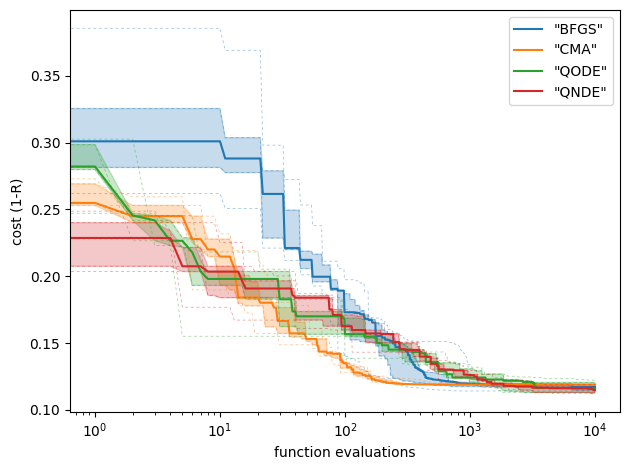

In [5]:
colors = [f'C{i}' for i in range(10)]

for i_opt, k in enumerate(hist_cost):
    for i, convergence in enumerate(hist_cost[k]):
        plt.plot(convergence, color=colors[i_opt], lw=0.5, alpha=0.5, dashes=[4,4])

    plt.plot(np.median(hist_cost[k], axis=0), color=colors[i_opt], label=f'"{k}"')
    plt.fill_between(np.arange(len(hist_cost[k][0])),
                     np.quantile(hist_cost[k], 0.25, axis=0),
                     np.quantile(hist_cost[k], 0.75, axis=0),
                     color=colors[i_opt],
                     alpha=0.25)

plt.xscale('log')

plt.xlabel('function evaluations')
plt.ylabel('cost (1-R)')
plt.legend()

plt.tight_layout()
plt.show()


## plot the consistency test

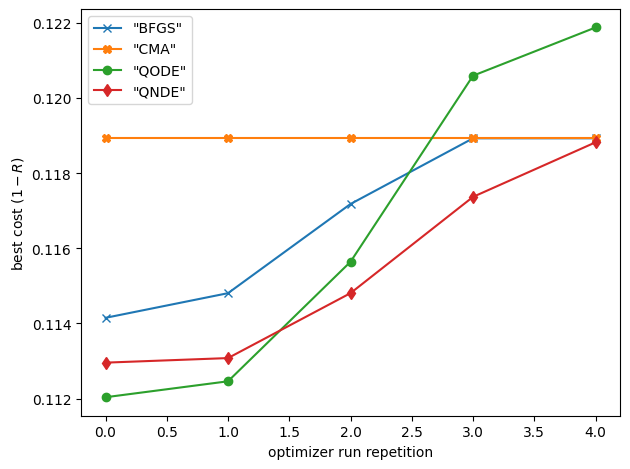

In [6]:
colors = [f'C{i}' for i in range(10)]
markers = ['x', 'X', 'o', 'd']

for i_opt, k in enumerate(hist_best_f):
    plt.plot(np.sort(hist_best_f[k]), color=colors[i_opt], marker=markers[i_opt], label=f'"{k}"')

plt.xlabel('optimizer run repetition')
plt.ylabel('best cost ($1-R$)')

plt.legend()
plt.tight_layout()
plt.show()